### Import Dependencies

In [1]:
#import libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
#Set up device agnostic code
device = (
    "cuda"
    if torch.cuda.is_available()
    else
    "cpu"
)

### Data Importation and Exploration

In [3]:
#Getting the data
#Training data
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None
                                   )

#Testing data
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None
                                  )

len(train_data), len(test_data)

100%|██████████| 26421880/26421880 [00:02<00:00, 10055869.80it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 172805.20it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 579353.10it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19791271.30it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(60000, 10000)

In [4]:
img, target = train_data[0]
img, target

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
img.shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Ankle boot')

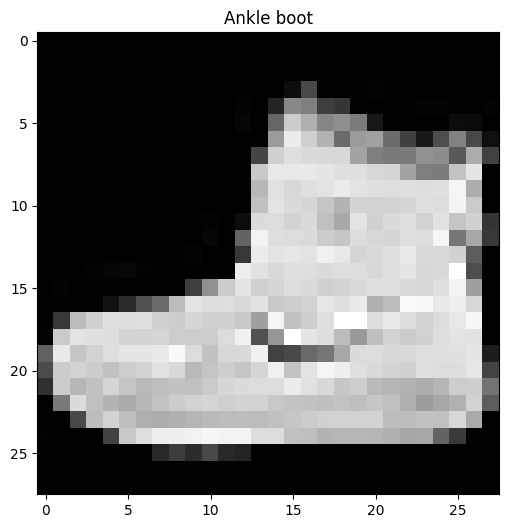

In [7]:
#Let's visualize an image
plt.figure(figsize=(8,6))
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[target])

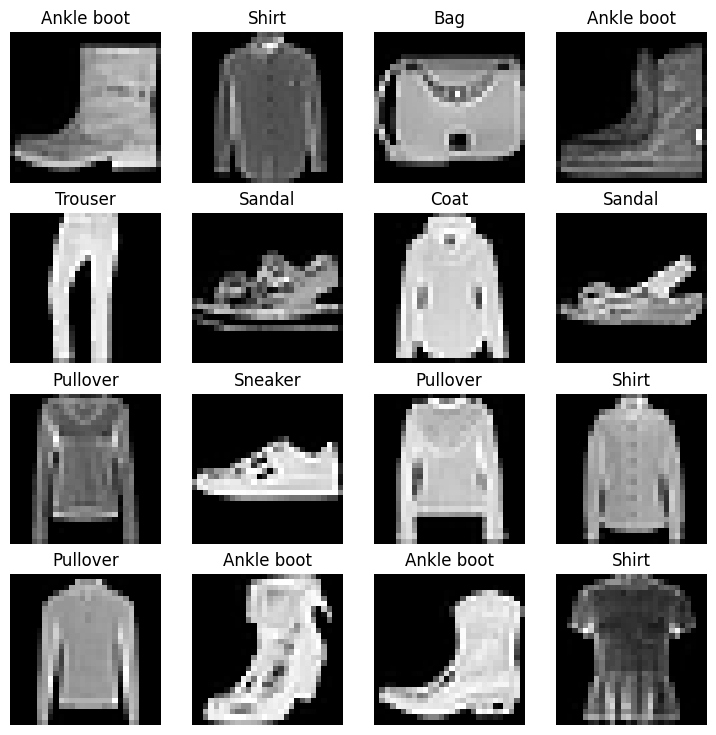

In [8]:
#Randomly plot more images
fig = plt.figure(figsize=(9, 9))
torch.manual_seed(42)
rows, cols= 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, target = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[target])
  plt.axis(False)



In [9]:
#Pass the data into a dataloader
#training dataloader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True,
                              )

#test dataloader

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

In [10]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [11]:

# Check the shape of dataloader
train_features_batch, train_target_batch = next(iter(train_dataloader))
train_features_batch.shape, train_target_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

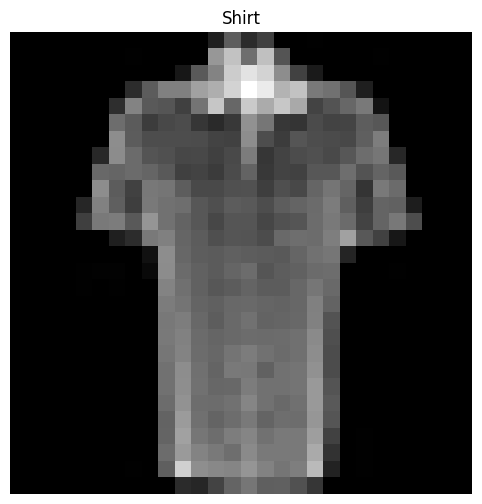

In [12]:
#Plot a sample of of the batched data
#set random seed for reproducibility
torch.manual_seed(42)

plt.figure(figsize=(8,6))
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, target = train_features_batch[random_idx], train_target_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[target])
plt.axis(False)


### Model Building

In [13]:
# Create a MNIST model by subclassing nn.Module
class MNISTModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        # nn.ReLU()
    )

  # create the fprward pass
  def forward(self, x):
    return self.layer_stack(x)


In [14]:
# Create an instance of the model
torch.manual_seed(42)

model = MNISTModel(input_shape=784,
                     hidden_units=16,
                     output_shape=len(class_names)
                     ).to(device)

model

MNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=10, bias=True)
  )
)

### Writing a training and testing loop

In [15]:
# Set up loss and optimizer
loss_fn = nn.CrossEntropyLoss()


# Setup optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [64]:
# Create am accuracy funvtion
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_true)) * 100
  return acc


# Training Loop
def train_loop(model, dataloader, loss_fn, optimizer, accuracy_fn):
  size = len(dataloader)
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    model.train()
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    acc = accuracy_fn(y, y_pred.argmax(dim=1))
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
  train_loss /= size
  train_acc /= size
  return train_loss, train_acc


# Testing Loop
def test_loop(model, dataloader, loss_fn, accuracy_fn):
  size = len(dataloader)
  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred = model(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss
      acc = accuracy_fn(y, test_pred.argmax(dim=1))
      test_acc += acc

    test_loss /= size
    test_acc /= size
    return test_loss, test_acc

In [65]:
def train(model, train_data, test_data, loss_fn, accuracy_fn, optimizer, epochs):
  # create an empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # loop through training anf test loops for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_loop(
        model=model,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_loss, test_acc = test_loop(
        model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

    # print out what is happening
    print(
        f"Epoch:  {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.2f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.2f}"
    )

    # Updata result dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results


In [66]:
# create an instance of the TinyVGG
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create an instance of the model
torch.manual_seed(42)

model = MNISTModel(input_shape=784,
                     hidden_units=16,
                     output_shape=len(class_names)
                     ).to(device)



# setup loss, accuracy and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_true))*100
  return acc

# start timer
from timeit import default_timer as timer
start_time = timer()

model_results = train(model=model,
                        train_data=train_dataloader,
                        test_data=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        accuracy_fn=accuracy_fn,
                        epochs=10)
# end the timer
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  1 | train_loss: 1.1385 | train_acc: 65.21 | test_loss: 0.7677 | test_acc: 74.05
Epoch:  2 | train_loss: 0.6696 | train_acc: 77.88 | test_loss: 0.6302 | test_acc: 78.72
Epoch:  3 | train_loss: 0.5785 | train_acc: 80.92 | test_loss: 0.5732 | test_acc: 80.46
Epoch:  4 | train_loss: 0.5327 | train_acc: 82.25 | test_loss: 0.5392 | test_acc: 81.45
Epoch:  5 | train_loss: 0.5050 | train_acc: 83.02 | test_loss: 0.5200 | test_acc: 81.99
Epoch:  6 | train_loss: 0.4859 | train_acc: 83.54 | test_loss: 0.5088 | test_acc: 82.44
Epoch:  7 | train_loss: 0.4712 | train_acc: 83.93 | test_loss: 0.4959 | test_acc: 82.79
Epoch:  8 | train_loss: 0.4605 | train_acc: 84.29 | test_loss: 0.4842 | test_acc: 83.23
Epoch:  9 | train_loss: 0.4515 | train_acc: 84.50 | test_loss: 0.4782 | test_acc: 83.34
Epoch:  10 | train_loss: 0.4446 | train_acc: 84.79 | test_loss: 0.4753 | test_acc: 83.25
Total training time: 111.732 seconds


In [67]:
model_results

{'train_loss': [tensor(1.1385, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6696, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.5785, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.5327, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.5050, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4859, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4712, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4605, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4515, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4446, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [65.21,
  77.875,
  80.915,
  82.25,
  83.02333333333333,
  83.53833333333333,
  83.92833333333333,
  84.29166666666667,
  84.5,
  84.79333333333334],
 'test_loss': [tensor(0.7677, device='cuda:0'),
  tensor(0.6302, device='cuda:0'),
  tensor(0.5732, device='cuda:0'),
  tensor(0.5392, device='cuda:0'),
  tensor(0.5200, device='cuda:0'),
  tensor(0.5088, device='cuda:0'),
  tenso

In [68]:

print(model_results["train_loss"])

[tensor(1.1385, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.6696, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.5785, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.5327, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.5050, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4859, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4712, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4605, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4515, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.4446, device='cuda:0', grad_fn=<DivBackward0>)]


In [71]:
# plot loss curves for model 0
def plot_loss_curves(results):


  # Get the loss values
  loss = [x.detach().cpu().numpy() for x in results["train_loss"]]
  test_loss = [x.detach().cpu().numpy() for x in results["test_loss"]]

  # Get the accuracy
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # get the number of epochs
  epochs = range(len(results["train_loss"]))
    # set up a plot
  plt.figure(figsize=(15,7))

  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # pplot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

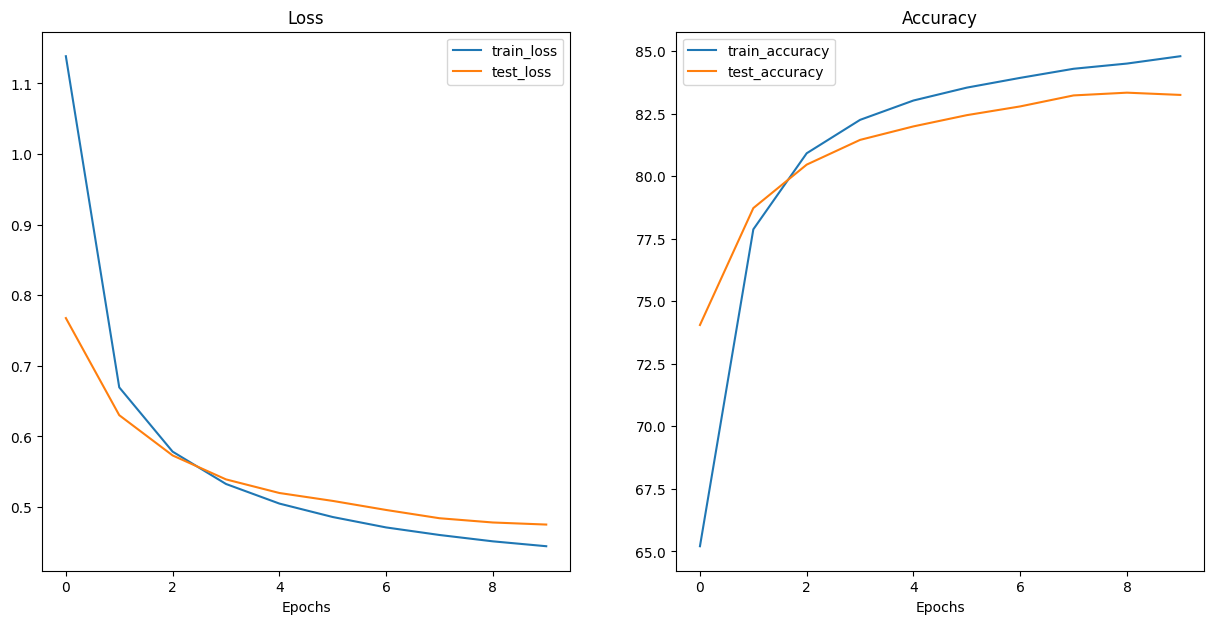

In [73]:
plot_loss_curves(model_results)

In [74]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [75]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [77]:
# Make predictions on test samples with model
pred_probs= make_predictions(model=model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.5432e-07, 1.5231e-07, 1.4948e-06, 1.0624e-07, 5.9016e-07, 8.7441e-01,
         3.0736e-06, 2.1852e-02, 9.4370e-04, 1.0279e-01],
        [7.2756e-02, 2.8405e-02, 1.1736e-02, 7.9647e-01, 6.0281e-02, 2.0149e-07,
         2.9560e-02, 2.1294e-06, 7.7504e-04, 1.7266e-05]])

In [80]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 3, 7, 4, 3, 0, 4, 7, 1])

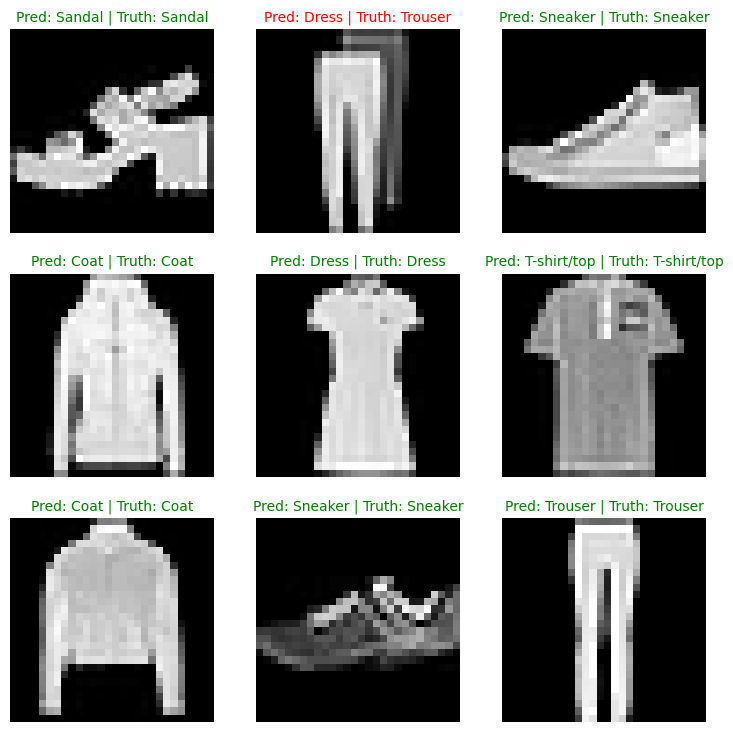

In [81]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [82]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [83]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 43.1 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [84]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


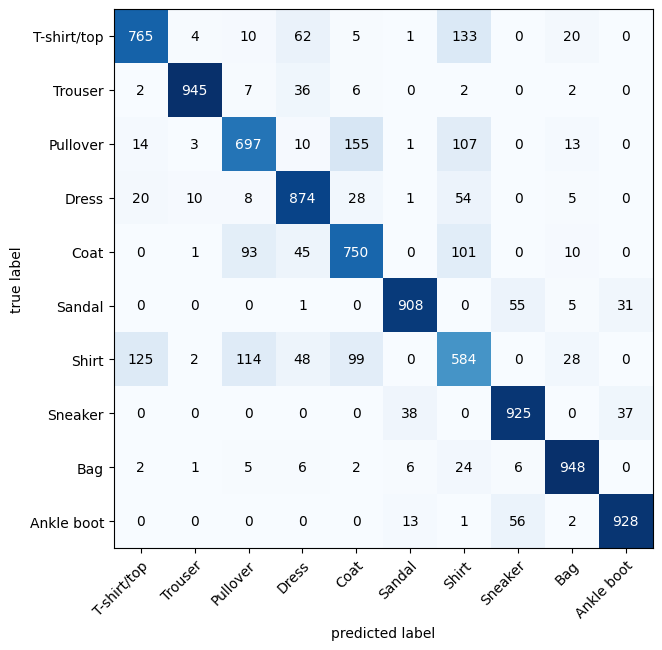

In [85]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)

In [87]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "fashion_image_classifer.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/fashion_image_classifer.pth
